# Evaluation of GPU memory consumption for CUDA Tensors

In [1]:
import sys
sys.path.append("/Users/danielherbst/Desktop/evaluation")

In [2]:
from evaluation_routines.data_loading import OCPDataFrameLoader
from evaluation_routines.cuda_memory import CUDAMemory
from evaluation_routines.runtimes import Runtimes

## Data loading

At first, we specify the paths necessary for evaluation. This includes:
- the ocp metrics directory stored in `ocp_metrics_path`
- the directory `directory` for the specific model/series of runs we would like to consider
- the runs `runs` as a `dict` with shorter name as key and the respective csv filenames without "_resources/..." extensions

In [3]:
ocp_metrics_path = "/Users/danielherbst/Desktop/ocp-metrics"
directory = "is2re/gemnet_xl/batch_size_2"

runs = {
    "S0":           "1658917929_stage0_8gpus",
    "S0+fp16":      "1658924014_stage0_8gpus",
    "S1":           "1658936306_stage1_8gpus",
    "S1+OC":        "1658928043_stage1_8gpus",
    "S2+OC":        "1658931854_stage2_8gpus",
    "S2+OO+OC":     "1658940077_stage2_8gpus_offloadOptimizer[cpu]",
    "S3+OC":        "1658945759_stage3_8gpus",
    "S3+PO+OO+OC":  "1658951594_stage3_8gpus_offloadOptimizer[cpu]_offloadParam[cpu]"
}
formatted_run_names_1 = [
    r"\textbf{S0}",
    r"\textbf{S0}" + "+fp16",
    r"\textbf{S1}",
    r"\textbf{S1}" + "+OC",
    r"\textbf{S2}" + "+OC",
    r"\textbf{S2}" + "+OO+OC",
    r"\textbf{S3}" + "+OC",
    r"\textbf{S3}" + "+PO+OO+OC"
]
formatted_run_names_2 = [
    r"\textbf{S0}",
    r"\textbf{S0}" + "+fp16",
    r"\textbf{S1}",
    r"\textbf{S1}" + "+OC",
    r"\textbf{S2}" + "+OC",
    r"\textbf{S2}" + "+OO\n+OC",
    r"\textbf{S3}" + "+OC",
    r"\textbf{S3}" + "+PO\n+OO+OC"
]

data_loader = OCPDataFrameLoader(ocp_metrics_path, directory, runs)
cuda_memory, runtimes = CUDAMemory(data_loader), Runtimes(data_loader)

In [4]:
resources_paths, torch_cuda_paths, runtimes_paths = data_loader.get_paths()

## Inspection of a single run

At first, we inspect single runs with a set DeepSpeed configuration. We look at statistical summaries of the allocated and reserved memory as well as runtimes.

In [5]:
cuda_df = data_loader.get_metrics_csv(torch_cuda_paths["S0"], csv_type="torch_cuda")
cuda_df

,datetime,epoch,rank,gpu_memory_allocated,gpu_memory_reserved
0,2022-07-27 10:32:13.792599,0,3,2879.627776,16674.455552
1,2022-07-27 10:32:13.792682,0,4,2877.000192,17033.068544
2,2022-07-27 10:32:13.792912,0,5,2884.348416,15766.388736
3,2022-07-27 10:32:13.792906,0,6,2872.742400,15720.251392
4,2022-07-27 10:32:13.792815,0,2,2888.310784,15529.410560
...,...,...,...,...,...
49995,2022-07-27 12:12:41.448550,0,5,2884.318208,41104.179200
49996,2022-07-27 12:12:41.448527,0,1,2889.186816,39980.105728
49997,2022-07-27 12:12:41.448579,0,0,2886.991360,31679.578112
49998,2022-07-27 12:12:41.448634,0,4,2876.891136,45634.027520


In [6]:
runtimes_df = data_loader.get_metrics_csv(runtimes_paths["S0"], csv_type="runtimes")
runtimes_df

,rank,epoch,epoch_time,dataloading_time,forward_time,backward_time,rest
0,7,0,6032.443668,9.344392,1578.132969,4258.682132,186.284175
1,6,0,6032.445155,9.183373,1479.306013,4258.938982,285.016787
2,0,0,6032.446597,7.652847,1338.754818,4259.195761,426.843171
3,2,0,6032.446688,10.148727,1396.206465,4258.506497,367.584999
4,5,0,6032.452734,9.703430,1475.788812,4258.606644,288.353848
5,4,0,6032.454291,10.129335,1533.609191,4257.715843,230.999922
6,1,0,6032.454442,9.599858,1378.196235,4258.844054,385.814296
7,3,0,6032.456173,10.334522,1476.425199,4257.381616,288.314837


In [7]:
runtimes.means("S0")

epoch_time          01:40:32
dataloading_time    00:00:09
forward_time        00:24:17
backward_time       01:10:58
rest                00:05:07
dtype: object

In [8]:
cuda_memory.summary_per_gpu("S0")

gpu_memory_allocated                                                   \
                    count         mean       std          min          25%   
rank                                                                         
0                  6250.0  2886.994465  0.049756  2886.835712  2886.961664   
1                  6250.0  2889.126173  0.052369  2888.963584  2889.091072   
2                  6250.0  2888.328543  0.050608  2888.147968  2888.293888   
3                  6250.0  2879.581425  0.056771  2879.405056  2879.543808   
4                  6250.0  2876.923275  0.068569  2876.736000  2876.874240   
5                  6250.0  2884.291702  0.057651  2884.119040  2884.252160   
6                  6250.0  2872.759744  0.054851  2872.568832  2872.722432   
7                  6250.0  2888.773198  0.059082  2888.592896  2888.733184   

                                            gpu_memory_reserved                \
              50%          75%          max               count          mean   
rank                                                                            
0     2886.996480  2887.029248  2887.194112              6250.0  31483.029000   
1     2889.127936  2889.162752  2889.310720              6250.0  39774.834141   
2     2888.330240  2888.362496  2888.563712              6250.0  32377.277765   
3     2879.582464  2879.620096  2879.781888              6250.0  43268.037075   
4     2876.921344  2876.967424  2877.135872              6250.0  42274.284655   
5     2884.293120  2884.329984  2884.516352              6250.0  34951.898931   
6     2872.761856  2872.795648  2873.002496              6250.0  30925.871750   
7     2888.774144  2888.813568  2888.989696              6250.0  35132.696250   

                                                                           \
              std           min           25%           50%           75%   
rank                                                                        
0     1201.990491  15305.015296  31679.578112  31679.578112  31679.578112   
1     1442.504094  15109.980160  39980.105728  39980.105728  39980.105728   
2      947.009138  15529.410560  32516.341760  32516.341760  32516.341760   
3     1703.474096  16674.455552  43505.418240  43505.418240  43505.418240   
4     2743.907272  17033.068544  42033.217536  42033.217536  45634.027520   
5     2538.499446  15766.388736  33988.542464  33988.542464  37450.940416   
6      730.808225  15720.251392  31046.238208  31046.238208  31046.238208   
7      962.014565  18530.435072  35284.582400  35284.582400  35284.582400   

                    
               max  
rank                
0     31679.578112  
1     39980.105728  
2     32516.341760  
3     43505.418240  
4     45634.027520  
5     41104.179200  
6     31046.238208  
7     35284.582400

In [9]:
cuda_memory.summary_averaged("S0")

,gpu_memory_allocated,gpu_memory_reserved
count,50000.000000,50000.000000
mean,2883.347316,36273.491196
std,5.803225,4869.851369
min,2872.568832,15109.980160
25%,2878.837760,31679.578112
50%,2885.676032,35284.582400
75%,2888.571008,39980.105728
max,2889.310720,45634.027520


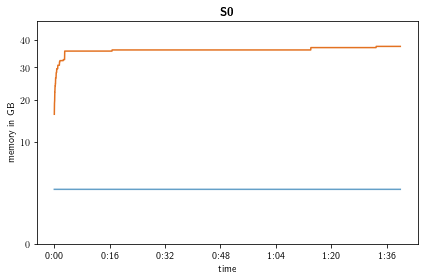

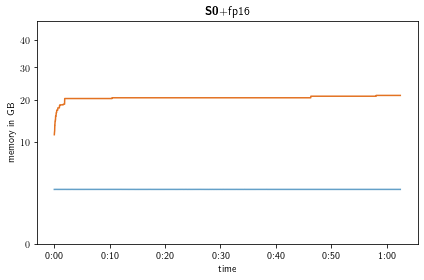

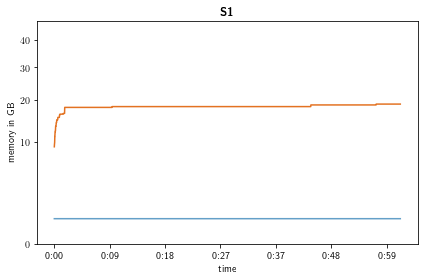

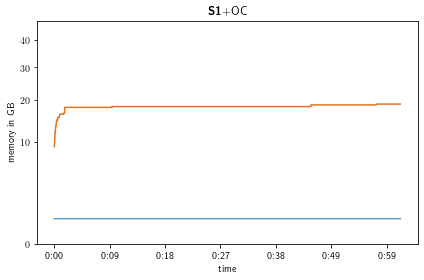

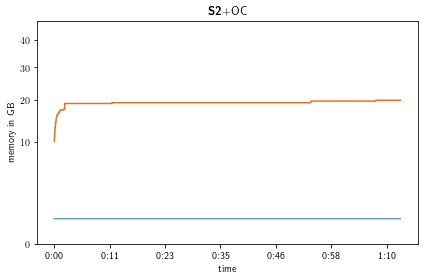

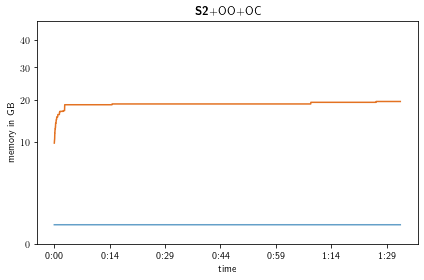

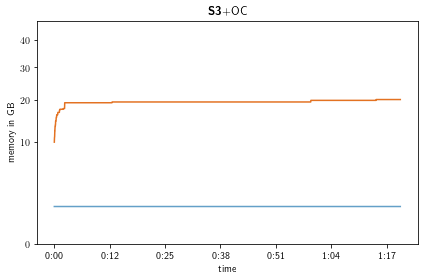

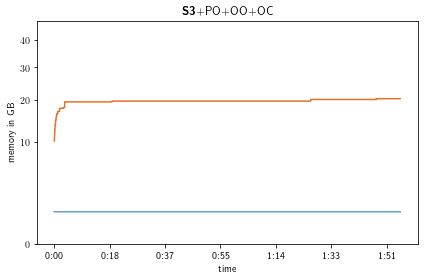

In [10]:
for i, run in enumerate(runs):
    cuda_memory.plot_cuda_memory(
        run, 
        mode="averaged", 
        title=formatted_run_names_1[i],
        save=True, 
        save_dir="../outputs/gemnet/is2re/cuda_memory"
    )

For a single run, the GPU CUDA torch memory consumption can be plotted versus time, individually on each GPU or averaged/summed across all involved GPUs.

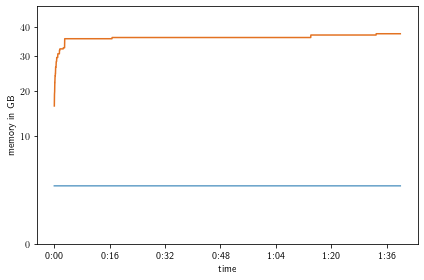

In [11]:
cuda_memory.plot_cuda_memory("S0", mode="averaged")

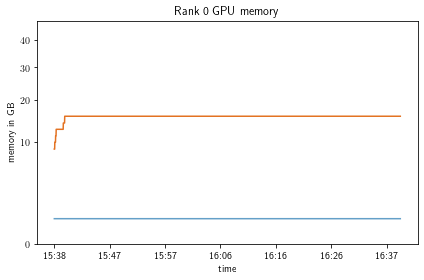

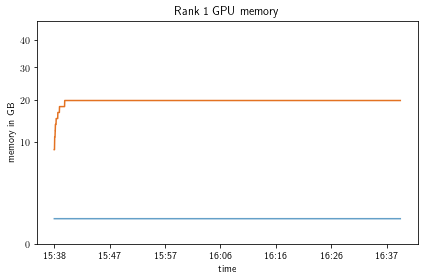

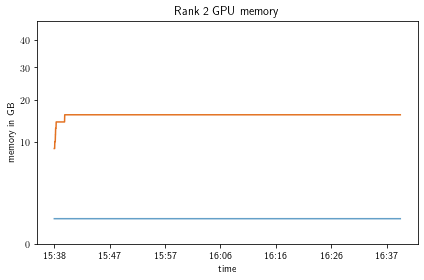

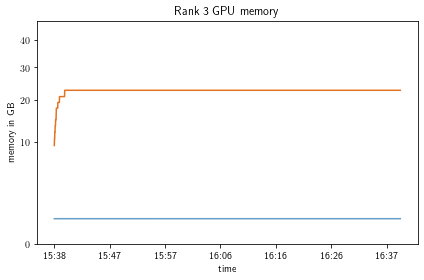

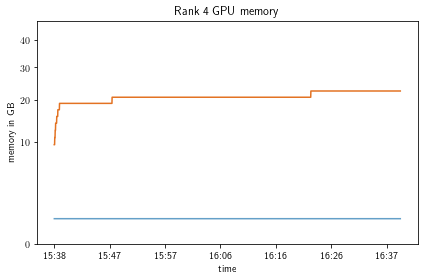

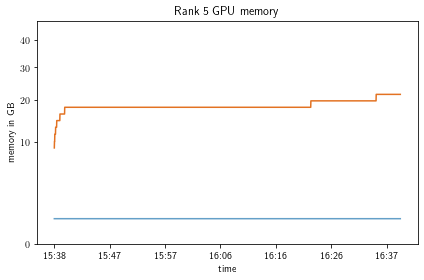

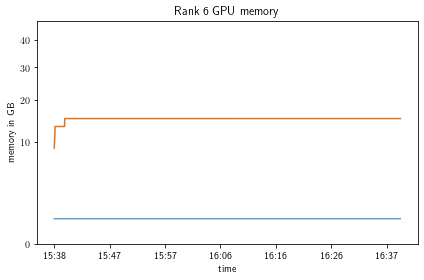

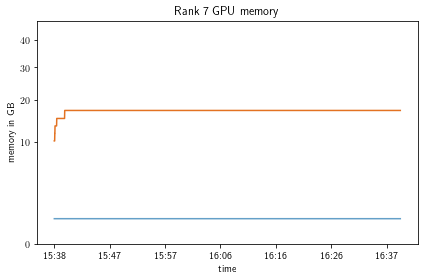

In [12]:
cuda_memory.plot_cuda_memory("S1", mode="individual")

## Comparison of memory and runtimes for different runs

For different runs, the allocated and reserved GPU CUDA memory as well as the runtimes can be compared.

In [13]:
runtimes.compare(save=True, save_dir="../outputs/gemnet/is2re/runtimes")

,S0,S0+fp16,S1,S1+OC,S2+OC,S2+OO+OC,S3+OC,S3+PO+OO+OC
epoch_time,01:40:32,01:03:09,01:01:58,01:02:39,01:13:23,01:33:50,01:20:55,01:56:20
dataloading_time,00:00:09,00:00:13,00:00:09,00:00:09,00:00:08,00:00:11,00:00:07,00:00:15
forward_time,00:24:17,00:15:43,00:16:07,00:16:06,00:16:04,00:16:07,00:27:31,00:27:30
backward_time,01:10:58,00:43:16,00:39:29,00:39:35,00:45:34,01:04:43,00:42:51,01:16:32
rest,00:05:07,00:03:55,00:06:12,00:06:47,00:11:35,00:12:47,00:10:25,00:12:01


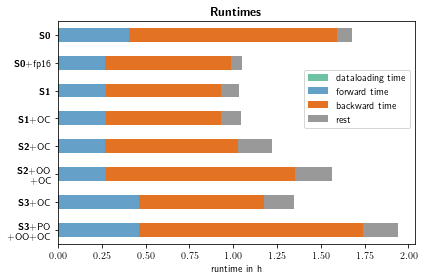

In [14]:
runtimes.compare_plot(
    yticks=formatted_run_names_2, 
    figsize=(6, 4), 
    title=r"\textbf{Runtimes}", 
    save=True, 
    save_dir="../outputs/gemnet/is2re/runtimes"
)

In [15]:
cuda_memory.compare(save=True, save_dir="../outputs/gemnet/is2re/cuda_memory")

,S0,S0+fp16,S1,S1+OC,S2+OC,S2+OO+OC,S3+OC,S3+PO+OO+OC
gpu_memory_allocated,2.88,2.88,0.62,0.62,0.62,0.36,1.36,1.00
gpu_memory_reserved,36.27,20.60,18.19,18.19,19.24,18.90,19.44,19.68


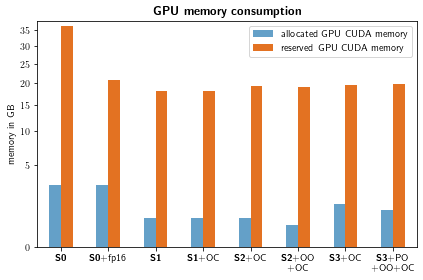

In [16]:
cuda_memory.compare_plot(
    xticks=formatted_run_names_2, 
    figsize=(6, 4), 
    title=r"\textbf{GPU memory consumption}", 
    save=True, 
    save_dir="../outputs/gemnet/is2re/cuda_memory"
)